# Python Notebook to demonstrate Vibration Mode Recognition Using A Combination Of DSP And Machine Learning

This program downloads an arbitrary number of .wav file recordings of rotating machines, displaying four different vibration modes, it then uses a subset of data from each file to train a Convolutional Neural Network (CNN) to recognize the different vibration modes then tests the model using a further subset of the data.

.wav file recordings can be downloaded from a website URL (GitHub Raw User Content) or copied from Google Drive /wav_files folder.

Prior to the CNN, the time domain vibration data is converted to the frequency domain. This allows a drastic reduction in the complexity of the CNN.

This file trains and tests the model, it also generates a Tensorflow Lite model, with 8 bit quantization, runs the model on the test sequence and prints the results.

The CNN architecture is shown in the following image. It has 128 input nodes, which are the 128 frequency domain coefficients between D.C. and the Nyquist frequency, for the 256 sample input frame of the time domain sequence. It has an output node for each classification category.

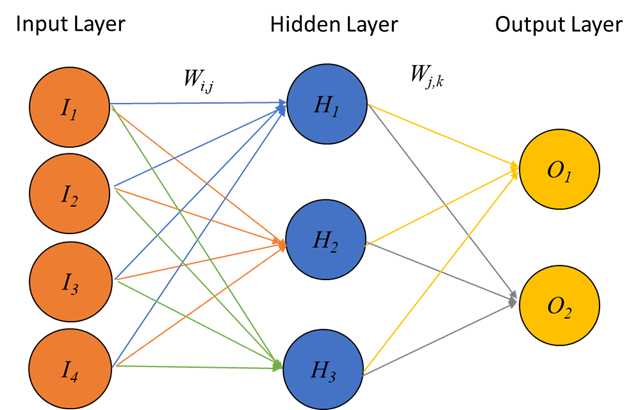

SigLib DSP Library can be downloaded from: https://github.com/Numerix-DSP/siglib

Sigma Numerix Ltd. Machine Learning capabilities are summarized here: https://numerix-dsp.com/ai/

**License**

This program is free software: you can redistribute it and/or modify 
it under the terms of the GNU General Public License as published by 
the Free Software Foundation, version 3.

This program is distributed in the hope that it will be useful, but 
WITHOUT ANY WARRANTY; without even the implied warranty of 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
General Public License for more details.
 
You should have received a copy of the GNU General Public License 
along with this program. If not, see <http://www.gnu.org/licenses/>.

Copyright (c) 2022, Sigma Numerix Ltd., All rights reserved

In [ ]:
import numpy as np
import tensorflow as tf
import os

from google.colab import drive
from matplotlib import pyplot as plt
from scipy.io import wavfile
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [ ]:
# Top level configuration

# .wav file sampling rate = 16 kHz
# Frame size = 256 samples
# Frame period = 16 ms

timeDomainFrameLength = 256
networkInputLayerNodes = timeDomainFrameLength >> 1

# Allow data to be stored in Google Drive or on a website
# Allows working online or, if we have copied the files locally, we can work off-line
if 'google.colab' in str(get_ipython()):
    drive.mount('/content/drive', force_remount=True)
    masterUrlRoot="/content/drive/MyDrive/wav_files/"
else:
    masterUrlRoot = 'https://raw.githubusercontent.com/Numerix-DSP/siglib/main/Examples/CExamples/MachineLearning/sourceData/'

# Input filenames:
wavFilenames = [
    'Machine1.wav',
    'Machine2.wav',
    # 'Machine3.wav',
    # 'Machine4.wav',
]

numClasses = len(wavFilenames)
print (f'numClasses: {numClasses}')


In [ ]:
# Load .wav files

wavData = []
for i in range(0, numClasses):
    if (os.path.exists(wavFilenames[i]) != True):          # If files are stored locally, we can skip this
        fileurl = masterUrlRoot + wavFilenames[i]
        print(f'Loading fileurl: {fileurl}')
        if 'https://' in fileurl:
            !wget -arg1 $fileurl
        else:
            !cp $fileurl .
    sampleRate, wd = wavfile.read(wavFilenames[i])
    wavData.append(wd)
    print(f'len(wavData{i}): {len(wavData[i])}')
    print(f'Sample Rate: {sampleRate}')


In [ ]:
# Plot data to verify it

plt.figure()
for i in range(0, numClasses):
    plt.plot(wavData[i], label=f'Machine {i}')
plt.legend(loc="best")
plt.show()
plt.close()


In [ ]:
# Create 2D arrays from waveforms
# Limit the array lengths to modulo timeDomainFrameLength

wav_2D_array = []
for i in range(0, numClasses):
    max_index = (len(wavData[i])//timeDomainFrameLength)*timeDomainFrameLength
    wavData[i] = wavData[i][:max_index]
    wav_2D_array.append(np.reshape(wavData[i], (-1, timeDomainFrameLength)))
    print(f'wav_2D_array[{i}] shape: {wav_2D_array[i].shape}')


In [ ]:
# Perform DSP Pre-processing on subframes

# Pre-process function for translating data from time to frequency domain
def pre_process(wav_2D_array):
    window = np.blackman(timeDomainFrameLength)

                # Create empty frequency domain Numpy array
    wav_fftd_2D_array = np.empty(shape=[0, networkInputLayerNodes])

    for i in range(len(wav_2D_array)):
        windowed = wav_2D_array[i] * window

                # Real to Real FFT and normalize for FFT scaling
        fftd = np.fft.fft(windowed, timeDomainFrameLength) / (timeDomainFrameLength/2.0)
        fftd = np.abs(fftd.real)

                # Truncate output to only include selected frequency domain coefficients from D.C. to Nyquist frequency
        fftd = fftd[0:networkInputLayerNodes]
        wav_fftd_2D_array = np.append(wav_fftd_2D_array, np.reshape(fftd, (-1, networkInputLayerNodes)), axis=0)
    return(wav_fftd_2D_array)

wav_fftd_2D_array = []
for i in range(0, numClasses):
    wav_fftd_2D_array.append(pre_process (wav_2D_array[i]))
    print(f'wav1_fftd_2D_array[{i}] shape: {wav_fftd_2D_array[i].shape}')


In [ ]:
# Split into training/validation (90%) and testing (10%) datasets

def split_array_train_test(wav_array, train_percentage):
    train_len = (len(wav_array) * (train_percentage)) // 100
    return wav_array[:train_len], wav_array[train_len:]

wav_xtrain = []
wav_xtest = []
for i in range(0, numClasses):
    wr, wt = split_array_train_test (wav_fftd_2D_array[i], 90)
    wav_xtrain.append(wr)
    wav_xtest.append(wt)

    print(f'wav{i} # subframes: {len(wav_fftd_2D_array[i])}')
    print(f'wav{i} train shape: {wav_xtrain[i].shape}')
    print(f'wav{i} test shape: {wav_xtest[i].shape}')


In [ ]:
# Create X and Y datasets for training, testing and validation

X_train = wav_xtrain[0]
X_test = wav_xtest[0]
for i in range(1, numClasses):
    X_train = np.concatenate((X_train, wav_xtrain[i]), axis=0)
    X_test = np.concatenate((X_test, wav_xtest[i]), axis=0)

# Create labels
wav_ytrain = []
wav_ytest = []
for i in range(0, numClasses):
    wav_ytrain.append(np.full(len(wav_xtrain[i]), i))
    wav_ytest.append(np.full(len(wav_xtest[i]), i))

y_train = wav_ytrain[0]
y_test = wav_ytest[0]
for i in range(1, numClasses):
    y_train = np.concatenate((y_train, wav_ytrain[i]), axis=0)
    y_test = np.concatenate((y_test, wav_ytest[i]), axis=0)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


In [ ]:
# Plot an arbitrary frame (100) of each class
# Don't plot first frame because there may be some zero padding in the source file

plt.figure()
for c in range(numClasses):
    c_X_train = X_train[y_train == c]
    plt.plot(c_X_train[100], label="Class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()


In [ ]:
# Reshape for Keras

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')


In [ ]:
# Time Series Classification Model
input_layer = tf.keras.layers.Input(shape=(networkInputLayerNodes,1))
conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=networkInputLayerNodes, activation='relu', use_bias=True)(input_layer)
output_layer = tf.keras.layers.Dense(numClasses, activation="sigmoid", use_bias=True)(conv1)

model_tsc = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model_tsc.summary()
tf.keras.utils.plot_model(model_tsc, show_shapes=True)


In [ ]:
# Train the model

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
]
model_tsc.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"])
history = model_tsc.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=4,
    shuffle=True,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1)


In [ ]:
# Test the model

model_tsc = tf.keras.models.load_model("best_model.h5")
test_loss, test_acc = model_tsc.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss:     {test_loss}')


In [ ]:
# Plot the accuracy as the CNN trains

metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.rcParams["figure.figsize"] = 12,5
plt.show()
plt.close()


In [ ]:
# Generate a confusion matrix to see which classes perform well or poorly
y_pred = model_tsc.predict(X_test)          # Returns probabilities

print(f'y_pred shape: {y_pred.shape}')

y_pred = np.argmax(y_pred, axis=-1)         # Return the index of the prediction with highest probability
print(f'y_test shape: {y_test.shape}')
print(f'y_pred shape: {y_pred.shape}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.rcParams["figure.figsize"] = 12,5
plt.show()


In [ ]:
# Convert to a Tensorflow Lite model for deployment on a microcontroller

converter = tf.lite.TFLiteConverter.from_keras_model(model_tsc)
converter.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS ]       # enable TensorFlow Lite ops.
tflite_model = converter.convert()
open("tsc.tflite", "wb").write(tflite_model)


In [ ]:
# Generate a quantized Tensorflow Lite model

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_tsc)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]     # If any ops can't be quantized the converter throws an error
converter.inference_input_type = tf.uint8           # Input and output tensor format
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
open("tsc_quant.tflite", "wb").write(tflite_model_quant)


In [ ]:
interpreter = tf.lite.Interpreter(model_path="tsc_quant.tflite")    # Load tensorflow lite model
interpreter.allocate_tensors()                      # Allocate tensors

input_details = interpreter.get_input_details()     # Get input and output tensor details
output_details = interpreter.get_output_details()

error_count = 0
num_test_sequences = X_test.shape[0]
print(f'num_test_sequences: {num_test_sequences}')
print(f'Max: {np.amax(X_test)}')
print(f'Min: {np.amin(X_test)}')

for i in range(0, num_test_sequences):
    X_temp=X_test[i].reshape(1, 128, 1) / 10.       # Reshape each frame for interpreting and scale for 8 bit
    input_data = np.array(X_temp, dtype=np.uint8)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])    # Return a copy of the tensor data
    max_index = np.argmax(output_data)              # Get category with highest probability
    if (max_index != y_test[i]):
        error_count += 1

print(f'error_count:   {error_count}')
print(f'Test accuracy: {(num_test_sequences-error_count)*100./num_test_sequences}')
print(f'Test loss:     {(error_count)*100./num_test_sequences}')
